## TSS mapping
### Add potential TSSs and TTSs and obtain the type of the TSSs (individual gene - wise)

In [2]:
# Import the required libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load the data
gene_depth_KO1 = pd.read_csv("Data_outputs/Depth_and_genes/genes_depth_KO1.txt")
gene_depth_KO2 = pd.read_csv("Data_outputs/Depth_and_genes/genes_depth_KO2.txt")
gene_depth_KO3 = pd.read_csv("Data_outputs/Depth_and_genes/genes_depth_KO3.txt")
gene_depth_WT1 = pd.read_csv("Data_outputs/Depth_and_genes/genes_depth_WT1.txt")
gene_depth_WT2 = pd.read_csv("Data_outputs/Depth_and_genes/genes_depth_WT2.txt")
gene_depth_WT3 = pd.read_csv("Data_outputs/Depth_and_genes/genes_depth_WT3.txt")

anot_file = pd.read_excel("Data_outputs/anot_file.xlsx")
anot_file = anot_file.drop(anot_file.columns[0], axis = 1)

# gene_depth_KO1.head(5)  # Data is properly loaded
anot_file.head(5)

,type,start,end,strand,gene_name
0,CDS,1,1524,+,dnaA
1,CDS,2052,3260,+,dnaN
2,CDS,3280,4437,+,recF
3,CDS,4434,4997,+,MB0004
4,CDS,5123,7267,+,gyrB


1. Add potential TSSs in the depth file:
    - Computation of the percentage of increase and decrease:

In [4]:
# Define function that calculates the % of increase and decrease per each dataframe. 
def per_of_inc(data):
    """Return the data frame with the % of increase of the depth"""

    data["Depth_diff"] = data["Depth"].diff()
    data["Depth_per_inc"] = (data["Depth_diff"] / data["Depth"].shift(1)) * 100  #Shift is used in data frames to shift the row values (if it's positive its moves the rows down)

    return data

gene_depth_KO1 = per_of_inc(gene_depth_KO1)
gene_depth_KO2 = per_of_inc(gene_depth_KO2)
gene_depth_KO3 = per_of_inc(gene_depth_KO3)
gene_depth_WT1 = per_of_inc(gene_depth_WT1)
gene_depth_WT2 = per_of_inc(gene_depth_WT2)
gene_depth_WT3 = per_of_inc(gene_depth_WT3)

In [5]:
# gene_depth_KO1.head(10)

- % of increase = 50% -> subsequent value has increased by half of its original value.
- % of decrease = 50% -> subsequent value has reduced to half of its original value.

- % of increase = 100% -> subsequent value is doubled
- % of decrease = 100% -> subsequent value is completely reduced to 0. 

(My % of decreae is negative becuase the operation is (current - old) in the numerator)

In [6]:
def TSS_TTS_anotation(data):
    """Performs TSS and TTS annotation, removes consecutive TUs, and cleans up TUs based on depth values"""   
    
    def TSSs_anot(data):
        """Returns potential TSSs of the input data frame"""

        data["TSS"] = ""        # initiate the new column that will store the TSS
        sig_depth = 10         # Threshold for significant depth
        perc_of_inc = 100        # Threshold for the percentage of increase
        
        mask = (data["Depth"] >= sig_depth) & (data["Depth_per_inc"] >= perc_of_inc)  # This is a boolean variable 
        data.loc[mask, "TSS"] = "TSS"   # df.loc[row_condition, column_condition] = value (value to assign to the selected rows and columns)

        return data

    def TTSs_anot(data):
        """Return potential TTSs of the input data """

        data["TTS"] = ""    # Create the TTSs column
        sig_depth = 200        
        perc_of_dec = - 50        # Decrease to the half of its original value. 

        data["Depth_diff_shifted"] = data["Depth_per_inc"].shift(-1)  # Shift the % of increase to be one row above (otherwise there's a mismatch)
        mask = (data["Depth"] >= sig_depth) & (data["Depth_diff_shifted"] <= perc_of_dec)
        data.loc[mask, "TTS"] = "TTS"
        
        return data


    def rm_area_TUs(data):
        """Checks each TU (TSS or TTS) in its surroundings and keeps the one with the highest (or lowest for TTS) depth value."""
        
        def process_TU(label, depth_func):
            for i in range(len(data)):
                if data.loc[i, label] == label:
                    # Define range of 50 positions above and below
                    start = max(i - 5, 0)
                    end = min(i + 5, len(data) - 1)
                    filtered_rows = data.loc[start:end]
                    
                    # Get depth values for the current label
                    depth_values = filtered_rows["Depth"][filtered_rows[label] == label]
                    
                    # Find the optimal depth value (max for TSS, min for TTS)
                    optimal_depth_value = depth_func(depth_values)
                    
                    # Identify indices to remove
                    indices_to_remove = depth_values[depth_values != optimal_depth_value].index
                    
                    # Set these indices to an empty string in the original data
                    data.loc[indices_to_remove, label] = ""
        
        process_TU("TSS", max)  # Data is directly modified when calling these functions
        process_TU("TTS", max)
    
        return data

    # Call the smaller functions in sequence
    data = TSSs_anot(data)
    data = TTSs_anot(data)
    data = rm_area_TUs(data)
    return data

final_depth_KO1 = TSS_TTS_anotation(gene_depth_KO1)
final_depth_KO2 = TSS_TTS_anotation(gene_depth_KO2)
final_depth_KO3 = TSS_TTS_anotation(gene_depth_KO3)
final_depth_WT1 = TSS_TTS_anotation(gene_depth_WT1)
final_depth_WT2 = TSS_TTS_anotation(gene_depth_WT2)
final_depth_WT3 = TSS_TTS_anotation(gene_depth_WT3)   

In [7]:
# final_depth_KO1.iloc[1- 1 : 2 + 15]  # For TTS location

In [8]:
# List of datasets and their corresponding output filenames
datasets = [
    (final_depth_KO1, "TUs_depth_KO1.txt"),
    (final_depth_KO2, "TUs_depth_KO2.txt"),
    (final_depth_KO3, "TUs_depth_KO3.txt"),
    (final_depth_WT1, "TUs_depth_WT1.txt"),
    (final_depth_WT2, "TUs_depth_WT2.txt"),
    (final_depth_WT3, "TUs_depth_WT3.txt")
]

# Columns to drop
columns_to_drop = ["Depth_diff", "Depth_per_inc", "Depth_diff_shifted"]

# Loop through each dataset, drop unnecessary columns, and save to CSV
for data, filename in datasets:
    data_dropped = data.drop(columns=columns_to_drop)
    data_dropped.to_csv(f"Data_outputs/Depth_genes_and_TUs/{filename}", index=False)

- Identification of TSS types (leader, leaderless or internal). 
By focusing on the TSSs, the idea is to loop through each gene in the depth data set and compare the position of the TSS with the starting position of the CDS of the gene. 
    - If the TSS is +- 5 bp of the start_gene -> Leaderless
    - If the TSS is between 150 - 5 bp upstream the start_gene -> Leader
    - If the TSS is in the middle of the gene -> Internal

In [9]:
def TSS_type(anot_file, depth_data):
    
    TSS_data = []  # store the Gene (key) and the TSS position and type as tuples
    
    for i in range(len(depth_data)):
    
        TSS_pos = 0  # Restart the position at each iteration
        closest_difference = None  # Initialize closest difference

        if depth_data.loc[i, "TSS"] == "TSS":  # If the position has a TSS
            TSS_pos = depth_data.loc[i,"Position"]
            gene_name = depth_data.loc[i, "Gene_name"]  # extract the gene name of the row
            TSS_class = "Unknown"  # Default classification
            depth = depth_data.loc[i, "Depth"]
            
            # Classify the leader/leaderless genes
            if gene_name == "no_gene":
                # Search in the annotation file the start position that is closer to this position. Reassign the gene name based on this gene. 
                diff_series = anot_file["start"][anot_file["type"] == "CDS"].astype(int) - TSS_pos
                positive_diff = diff_series[diff_series > 0]  # Because we want the gene name that is below this position
    
                if not positive_diff.empty and (positive_diff < 200).any():
                    # Find the closest gene with the smallest positive difference
                    closest_index = positive_diff.idxmin()  # Get the index of the smallest positive difference
                    closest_gene = anot_file.loc[closest_index]  # Use the index to get the row
                    gene_name = closest_gene["gene_name"]
                    closest_difference = positive_diff.loc[closest_index]  # Get the difference
                    # print(closest_difference)
                
                if closest_difference is not None:  # Only classify if we found a closest gene
                    if 5 < closest_difference <= 300:
                        TSS_class = "Leader"
                    elif closest_difference <= 5:
                        TSS_class = "Leaderless"
            
            # Classify the internal/leaderless genes
            elif gene_name != "no_gene":
                diff_series = anot_file["start"][anot_file["type"] == "CDS"].astype(int) - TSS_pos
                negative_diff = diff_series[diff_series < 0]

                if not negative_diff.empty:
                    # Find the closest gene with the smallest positive difference
                    closest_index = negative_diff.idxmax()  # Get the index of the largest negative difference
                    closest_difference = negative_diff.loc[closest_index]  # Get the difference

                if closest_difference is not None:
                    if abs(closest_difference) <= 5:
                        TSS_class = "Leaderless"
                    else:
                        TSS_class = "Internal"

            # Handle the TSSs classified as unknown 
            if TSS_class == "Unknown":
                abs_diff_sta = abs(anot_file["start"][anot_file["type"] != "CDS"].astype(int) - TSS_pos)
                abs_diff_end = abs(anot_file["end"][anot_file["type"] != "CDS"].astype(int) - TSS_pos)

                # Check if the distance to either the start or end of non-CDS features is less than 200
                if (abs_diff_sta < 200).any() or (abs_diff_end < 10).any() :
                    closest_sta_index = abs_diff_sta.idxmin()
                    closest_end_index = abs_diff_end.idxmin()

                # Determine which distance is smaller and classify the TSS
                    if abs_diff_sta.loc[closest_sta_index] < abs_diff_end.loc[closest_end_index]:
                        closest_index = closest_sta_index
                        TSS_class = f"Unknown_{anot_file.loc[closest_index,'type']}"
                    else:
                        closest_index = closest_end_index
                        TSS_class = f"Unknown_{anot_file.loc[closest_index,'type']}"

                    # Extract gene name
                    gene_name = anot_file.loc[closest_index,'gene_name']
                else:
                    TSS_class = "Unknown"

            # Add the direction of the gene
            if gene_name in anot_file["gene_name"].values:
                direction = anot_file.loc[anot_file["gene_name"] == gene_name, "strand"].iloc[0]
            else:
                direction = "Unknown"  # Handle cases where the gene is not in the annotation file

            # Append the TSS information to the list
            TSS_data.append({
                "TSS_position": TSS_pos,
                "TSS_depth": depth,
                "TSS_type": TSS_class,
                "Gene_name": gene_name,
                "Strand" : direction,
            })
        
        # Convert the list of dictionaries to a DataFrame
    TSS_df = pd.DataFrame(TSS_data)
                
    return  TSS_df       
                                  
       
TSS_list_KO1 = TSS_type(anot_file, final_depth_KO1)
TSS_list_KO1.to_excel("Data_outputs/TSS_data/KO1_TSS_list.xlsx", index=False)

TSS_list_KO2 = TSS_type(anot_file, final_depth_KO2)
TSS_list_KO2.to_excel("Data_outputs/TSS_data/KO2_TSS_list.xlsx", index=False)

TSS_list_KO3 = TSS_type(anot_file, final_depth_KO3)
TSS_list_KO3.to_excel("Data_outputs/TSS_data/KO3_TSS_list.xlsx", index=False)

TSS_list_WT1 = TSS_type(anot_file, final_depth_WT1)
TSS_list_WT1.to_excel("Data_outputs/TSS_data/WT1_TSS_list.xlsx", index=False)

TSS_list_WT2 = TSS_type(anot_file, final_depth_WT2)
TSS_list_WT2.to_excel("Data_outputs/TSS_data/WT2_TSS_list.xlsx", index=False)

TSS_list_WT3 = TSS_type(anot_file, final_depth_WT3)
TSS_list_WT3.to_excel("Data_outputs/TSS_data/WT3_TSS_list.xlsx", index=False)

Get the same type of table for the TTSs for the verification with the replicates.

In [10]:
def table_TTSs(data):
    """Converts the depth data to a table with the TTS and the gene it belongs to"""
    
    TSSs_data = []
    for i in range(len(data)):
        if data.loc[i, "TTS"] == "TTS":
           TTS_pos = data.loc[i,"Position"]
           gen_name = data.loc[i,"Gene_name"]
           TSSs_data.append({"TTS_position":TTS_pos, "Gene_name":gen_name}) 

    TTS_df = pd.DataFrame(TSSs_data)

    return TTS_df

TTS_list_KO1 = table_TTSs(final_depth_KO1)
TTS_list_KO1.to_excel("Data_outputs/TTS_data/KO1_TTS_list.xlsx", index=False)

TTS_list_KO2 = table_TTSs(final_depth_KO2)
TTS_list_KO2.to_excel("Data_outputs/TTS_data/KO2_TTS_list.xlsx", index=False)

TTS_list_KO3 = table_TTSs(final_depth_KO3)
TTS_list_KO3.to_excel("Data_outputs/TTS_data/KO3_TTS_list.xlsx", index=False)

TTS_list_WT1 = table_TTSs(final_depth_WT1)
TTS_list_WT1.to_excel("Data_outputs/TTS_data/WT1_TTS_list.xlsx", index=False)

TTS_list_WT2 = table_TTSs(final_depth_WT2)
TTS_list_WT2.to_excel("Data_outputs/TTS_data/WT2_TTS_list.xlsx", index=False)

TTS_list_WT3 = table_TTSs(final_depth_WT3)
TTS_list_WT3.to_excel("Data_outputs/TTS_data/WT3_TTS_list.xlsx", index=False)


### TSS and TTS verification (individual gene - wise)

In [11]:
def final_TUs(data_1, data_2, data_3, TU_type, window=10):
    """Identify TSS positions present within a defined window across three replicates."""
 
    final_positions = []  # List to store the matching positions

    # Function to check if position is close to any existing position in the list
    def is_position_nearby(pos, final_positions, window):
        return any(abs(pos - existing_pos) <= window for existing_pos in final_positions)

    for i in range(len(data_1)):
        pos_TSS_d1 = data_1.loc[i, f"{TU_type}_position"]
        
        match_in_d2 = any(abs(pos_TSS_d1 - pos_TSS_d2) <= window for pos_TSS_d2 in data_2[f"{TU_type}_position"])
        match_in_d3 = any(abs(pos_TSS_d1 - pos_TSS_d3) <= window for pos_TSS_d3 in data_3[f"{TU_type}_position"])

        # If the TSS is found in at least two of the datasets, append it
        if match_in_d2 or match_in_d3:            
            final_positions.append(data_1.loc[i].to_dict())

    for i in range(len(data_2)):
        pos_TSS_d2 = data_2.loc[i, f"{TU_type}_position"]
        
        match_in_d2 = any(abs(pos_TSS_d2 - pos_TSS_d3) <= window for pos_TSS_d3 in data_3[f"{TU_type}_position"])
        
        if match_in_d2:
            if not is_position_nearby(pos_TSS_d2, [p[f"{TU_type}_position"] for p in final_positions], window):
                final_positions.append(data_2.loc[i].to_dict())

    # Convert the results into a DataFrame
    final_df = pd.DataFrame(final_positions)

    # Sort the data frame to have the TSS from lowest position to the largest
    final_df = final_df.sort_values(by = f"{TU_type}_position")

    return final_df


In [12]:
# TSS
final_TSS_KO = final_TUs(TSS_list_KO3, TSS_list_KO2, TSS_list_KO1, window=10, TU_type = "TSS")
final_TSS_KO.to_excel("Data_outputs/TSS_data_final/final_TSS_KO.xlsx", index=False)
final_TSS_WT = final_TUs(TSS_list_WT3, TSS_list_WT2, TSS_list_WT1, window=10, TU_type = "TSS")
final_TSS_WT.to_excel("Data_outputs/TSS_data_final/final_TSS_WT.xlsx", index=False)

# TTS
final_TTS_KO = final_TUs(TTS_list_KO3, TTS_list_KO2, TTS_list_KO1, window=10, TU_type = "TTS")
final_TTS_KO.to_excel("Data_outputs/TTS_data_final/final_TTS_KO.xlsx", index=False)
final_TTS_WT = final_TUs(TTS_list_WT3, TTS_list_WT2, TTS_list_WT1, window=10, TU_type = "TTS")
final_TTS_WT.to_excel("Data_outputs/TTS_data_final/final_TTS_WT.xlsx", index=False)

For the bar plots, of the final number of TSS, take into consideration that the internal TSS lower than 300 depth value will be filtered out

In [13]:
# Filter out those internal containing less than 300 of depth and re do the bar plot and subsequent plots.

# The bar plot needs to be thone using final TSS.  m

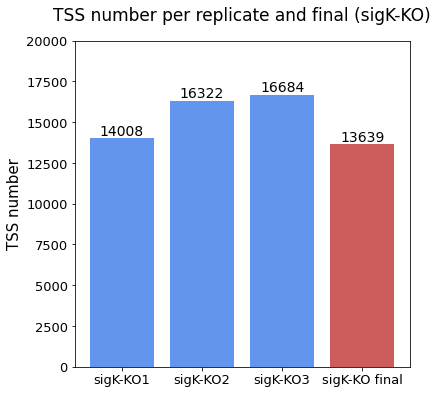

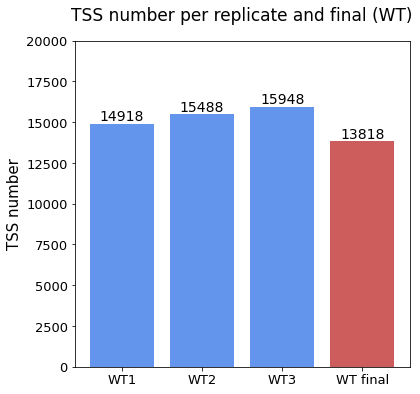

In [14]:
# Make a bar plot of the length the the TSS and TTS
def bar_plot(data1, data2, data3, data_final, TU_type):

    counts_data = [len(data1[data1["TSS"] == "TSS"]), len(data2[data2["TSS"] == "TSS"]), len(data3[data3["TSS"] == "TSS"]), len(data_final)]

    labels = [f"{TU_type}1", f"{TU_type}2", f"{TU_type}3", f"{TU_type} final"]
    colors = ["cornflowerblue", "cornflowerblue", "cornflowerblue", "indianred",]

    plt.figure(figsize=(6,6))
    plt.bar(labels, counts_data, color = colors)
    for i, counts in enumerate(counts_data):
        plt.text(x=i, y= counts + 5, s = str(counts), ha='center', va='bottom', fontsize=14)

    plt.title(f"TSS number per replicate and final ({TU_type})", fontsize = 17, pad=20)
    plt.ylabel("TSS number", fontsize = 15)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.ylim(0,20000)
    plt.show()

bar_plot(final_depth_KO1, final_depth_KO2, final_depth_KO3, final_TSS_KO, "sigK-KO")
bar_plot(final_depth_WT1, final_depth_WT2, final_depth_WT3, final_TSS_WT, "WT")

# counts_TTS = [len(TUs_depth_KO1[TUs_depth_KO1["TTS"] == "TTS"]),
#         len(TUs_depth_KO2[TUs_depth_KO2["TTS"] == "TTS"]),
#         len(TUs_depth_KO3[TUs_depth_KO3["TTS"] == "TTS"]),
#         len(final_TTS_KO),
#         len(TUs_depth_WT1[TUs_depth_WT1["TTS"] == "TTS"]),
#         len(TUs_depth_WT2[TUs_depth_WT2["TTS"] == "TTS"]),
#         len(TUs_depth_WT3[TUs_depth_WT3["TTS"] == "TTS"]),
#         len(final_TTS_WT)]

# labels = ["KO1", "KO2", "KO3", "KO", "WT1", "WT2", "WT3", "WT"]
# colors = ["cornflowerblue", "cornflowerblue", "cornflowerblue", "indianred", "cornflowerblue", "cornflowerblue", "cornflowerblue", "indianred"]

# plt.bar(labels, counts_TTS, color = colors)
# plt.title("TTS number per replicate")
# plt.ylabel("Counts")
# plt.show()
# print(counts_TTS)


#### Data analysis (individual gene - wise)
Similarity of TSS positions between KO and WT group

- TSS position-wise: Here we need to consider that biological data can have some variations, and hence the metrics used will need to account for this variation. 

final_TSS_KO["TSS_position"]                                              -> pandas object. 
final_TSS_KO["TSS_position"].values                                       -> numpy array
final_TSS_KO["TSS_position"].values - final_TSS_WT["TSS_position"].values -> Error because the lenghts of the arrays differ and the element-wise substraction cannot be computed. 

GOAL: make a matrix that contains the differences between the different elements. This will be of size (13639, 13818)
final_TSS_KO["TSS_position"].values[:, None]  -> creates a column vector (a 2D array with shape (n, 1), where n is the number of positions in final_TSS_KO).
final_TSS_WT["TSS_position"].values           -> 1D array with shape (m,), where m is the number of positions in final_TSS_WT

Broadcasting -> expands the cols of the array (n,1) to match the ones of (m,), to perform the substraction. Basically each element in the 1D array is substracted from the whole column. That's how we get the matrix (if its hard to udnerstand, try it with smaller numbers)

10674 559 2406


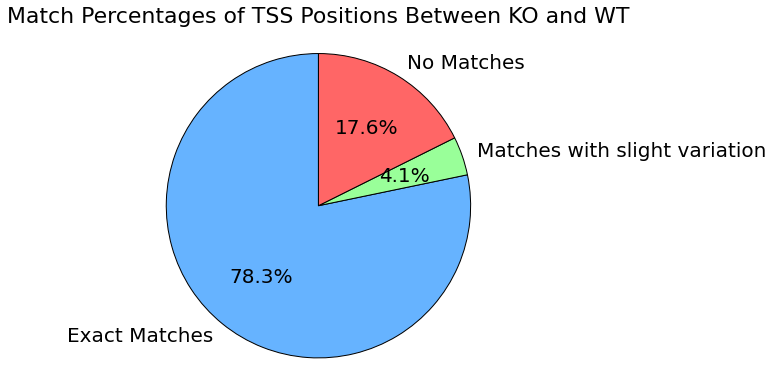

In [15]:
# 1- Make a pie chart which contains percentages of the exact positions that match, the ones that almost match and the ones that do not match (nested for loops are too inefficient, try vectorization)

# Get the exact matches
exact_matches_KO = final_TSS_KO["TSS_position"].isin(final_TSS_WT["TSS_position"])
exact_matches_WT = final_TSS_WT["TSS_position"].isin(final_TSS_KO["TSS_position"])

# Perform a preprocess step to remove the exact matches from the dataframes
proc_final_TSS_KO = final_TSS_KO[~exact_matches_KO]
proc_final_TSS_WT = final_TSS_WT[~exact_matches_WT]

# Make the matrix (shape = 13639, 13818) to get the almost matches 
diff_matrix = np.abs(proc_final_TSS_KO["TSS_position"].values[:, None] - proc_final_TSS_WT["TSS_position"].values)
# diff_matrix.shape

# Get those numbers whose difference is < 10
almost_matches_mask = (diff_matrix < 10).any(axis=1)  # Without the axis, it would check in the entire matrix if there's any TRUE value and it will return TRUE if so. 
                                                    # by specifing the axis, you are applying the operation along a particular axis, and hence checking each row/column to see if there're any True elements.


# Get the total number
exact_count = exact_matches_KO.sum()
almost_count = almost_matches_mask.sum()
no_match_count = len(final_TSS_KO) - (exact_count + almost_count)
print(exact_count, almost_count, no_match_count)

# Pie chart
labels = ["Exact Matches", "Matches with slight variation", "No Matches"]
sizes = [exact_count, almost_count, no_match_count]
colors = ['#66b3ff', '#99ff99', '#ff6666']


plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 20}, wedgeprops={'linewidth': 1, 'edgecolor': 'black'})
plt.title('Match Percentages of TSS Positions Between KO and WT', fontsize = 22, pad = 20)
plt.axis('equal') 
plt.show()

2. Focusing on the genes mainly regulated by sigK, get some statistics of the TSS and see how they differ in the WT and KO group.

In [16]:
downr_gene_names = ["mpt70", "MB2902c", "MB0457c","dipZ", "mpt83", "ufaA1", "MB0454c", "MB0456c", "sigK"]
upr_gene_names = ["MB1762c", "MB1767", "MB1768c", "MB2019", "ctpF", "MB2021c", "MB2028c", "fdxA", "hspX", "acg", 'hrp1', "MB2660c", "MB2661", "MB3149c", 'MB3150', 'MB3152c', 'tgs1', 'MB3155']


def TSS_Sigk_genes(data, gene_names):
    """""Returns a dataframe containing the counts of the TSS types per each gene"""
    
    dict = {"Gene_name":[], "n_leader":[], "n_leaderless": [], "n_internal":[], "total_TSSs":[] }
    for gene in gene_names:
        tss_pd = data[data["Gene_name"] == gene]
        n_leader = (tss_pd["TSS_type"] == "Leader").sum()
        n_leaderless = (tss_pd["TSS_type"] == "Leaderless").sum()
        n_internal = (tss_pd["TSS_type"] == "Internal").sum()
        total_TSS = len(tss_pd)

        dict["Gene_name"].append(gene)
        dict["n_leader"].append(n_leader)
        dict["n_leaderless"].append(n_leaderless)
        dict["n_internal"].append(n_internal)
        dict["total_TSSs"].append(total_TSS)

    Sigk_regulon = pd.DataFrame(dict)
    return Sigk_regulon

TSS_Sigk_genes_KO = TSS_Sigk_genes(final_TSS_KO, downr_gene_names)
TSS_Sigk_genes_WT = TSS_Sigk_genes(final_TSS_WT, downr_gene_names)



In [17]:
print(TSS_Sigk_genes_KO)
print(TSS_Sigk_genes_WT)

  Gene_name  n_leader  n_leaderless  n_internal  total_TSSs
0     mpt70         0             0           3           3
1   MB2902c         0             0           1           1
2   MB0457c         0             0           3           3
3      dipZ         0             0           6           6
4     mpt83         0             0           2           2
5     ufaA1         0             0           4           4
6   MB0454c         0             0           1           1
7   MB0456c         0             0           2           2
8      sigK         0             0           4           4
  Gene_name  n_leader  n_leaderless  n_internal  total_TSSs
0     mpt70         1             0           3           4
1   MB2902c         0             0           1           1
2   MB0457c         0             0           6           6
3      dipZ         0             0          10          10
4     mpt83         1             0           1           2
5     ufaA1         0             0     